# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def getCIFAR10Data(numTraining = 49000, numValidation = 1000, numTest = 1000, numDev = 500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10Dir = 'cs231n/datasets/cifar-10-batches-py'
    XTrain, yTrain, XTest, yTest = load_CIFAR10(cifar10Dir)

    # subsample the data
    mask = range(numTraining, numTraining + numValidation)
    XVal = XTrain[mask]
    yVal = yTrain[mask]
    mask = range(numTraining)
    XTrain = XTrain[mask]
    yTrain = yTrain[mask]
    mask = range(numTest)
    XTest = XTest[mask]
    yTest = yTest[mask]
    mask = np.random.choice(numTraining, numDev, replace = False)
    XDev = XTrain[mask]
    yDev = yTrain[mask]

    # Preprocessing: reshape the image data into rows
    XTrain = np.reshape(XTrain, (XTrain.shape[0], -1))
    XVal = np.reshape(XVal, (XVal.shape[0], -1))
    XTest = np.reshape(XTest, (XTest.shape[0], -1))
    XDev = np.reshape(XDev, (XDev.shape[0], -1))

    # Normalize the data: subtract the mean image
    meanImage = np.mean(XTrain, axis = 0)
    XTrain -= meanImage
    XVal -= meanImage
    XTest -= meanImage
    XDev -= meanImage

    # add bias dimension and transform into columns
    XTrain = np.hstack([XTrain, np.ones((XTrain.shape[0], 1))])
    XVal = np.hstack([XVal, np.ones((XVal.shape[0], 1))])
    XTest = np.hstack([XTest, np.ones((XTest.shape[0], 1))])
    XDev = np.hstack([XDev, np.ones((XDev.shape[0], 1))])

    return XTrain, yTrain, XVal, yVal, XTest, yTest, XDev, yDev


# Invoke the above function to get our data.
XTrain, yTrain, XVal, yVal, XTest, yTest, XDev, yDev = getCIFAR10Data()
print('Train data shape: ', XTrain.shape)
print('Train labels shape: ', yTrain.shape)
print('Validation data shape: ', XVal.shape)
print('Validation labels shape: ', yVal.shape)
print('Test data shape: ', XTest.shape)
print('Test labels shape: ', yTest.shape)
print('dev data shape: ', XDev.shape)
print('dev labels shape: ', yDev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmaxLossNaive function.

import time
from cs231n.classifiers.softmax import softmaxLossNaive

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmaxLossNaive(W, XDev, yDev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.376040
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmaxLossNaive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmaxLossNaive(W, XDev, yDev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmaxLossNaive(w, XDev, yDev, 0.0)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmaxLossNaive(W, XDev, yDev, 1e2)
f = lambda w: softmaxLossNaive(w, XDev, yDev, 1e2)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.488291 analytic: -3.488291, relative error: 1.372416e-08
numerical: -4.163022 analytic: -4.163022, relative error: 3.846564e-09
numerical: -3.147927 analytic: -3.147927, relative error: 1.293018e-09
numerical: 1.160977 analytic: 1.160977, relative error: 2.559386e-08
numerical: 1.952518 analytic: 1.952517, relative error: 4.005452e-08
numerical: 1.105831 analytic: 1.105831, relative error: 6.596845e-09
numerical: -0.339476 analytic: -0.339476, relative error: 3.536029e-09
numerical: -0.631969 analytic: -0.631969, relative error: 6.505832e-08
numerical: -4.362532 analytic: -4.362532, relative error: 6.939640e-09
numerical: -1.268686 analytic: -1.268686, relative error: 2.328614e-08
numerical: 1.856829 analytic: 1.856828, relative error: 5.169268e-08
numerical: -0.475671 analytic: -0.475671, relative error: 2.457321e-09
numerical: 2.438341 analytic: 2.438341, relative error: 4.053997e-10
numerical: 2.101727 analytic: 2.101727, relative error: 2.120228e-08
numerical: 0.98199

In [5]:
from cs231n.classifiers.softmax import softmaxLossVectorized

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmaxLossVectorized(W, XDev, yDev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmaxLossVectorized(w, XDev, yDev, 0.0)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmaxLossVectorized(W, XDev, yDev, 1e2)
f = lambda w: softmaxLossVectorized(w, XDev, yDev, 1e2)[0]
gradNumerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.245866 analytic: 1.245866, relative error: 2.814769e-08
numerical: -0.895932 analytic: -0.895932, relative error: 8.464219e-09
numerical: 0.237035 analytic: 0.237035, relative error: 2.029442e-09
numerical: -0.252858 analytic: -0.252858, relative error: 1.958018e-07
numerical: 0.543924 analytic: 0.543924, relative error: 1.105324e-07
numerical: 0.751809 analytic: 0.751809, relative error: 5.444228e-08
numerical: 3.231521 analytic: 3.231521, relative error: 2.157306e-11
numerical: 0.444735 analytic: 0.444735, relative error: 3.117898e-08
numerical: -0.567676 analytic: -0.567676, relative error: 3.608478e-08
numerical: -2.134691 analytic: -2.134691, relative error: 1.042626e-08
numerical: -0.247437 analytic: -0.247437, relative error: 1.847324e-08
numerical: 0.476913 analytic: 0.476913, relative error: 4.859043e-08
numerical: 0.009438 analytic: 0.009438, relative error: 1.792852e-06
numerical: -3.086891 analytic: -3.086891, relative error: 3.962550e-09
numerical: 0.881317 an

In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
bestVal = -1
bestSoftmax = None

learningRates = [1e-8, 1e-7, 5e-7, 1e-6]
regularizationStrengths = [5e2, 1e3, 1e4, 5e4]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in bestSoftmax.                           #
################################################################################

## Converting the learning rate and regularization strenghts list into numpy arrays.
learningRates = np.array(learningRates)
regularizationStrengths = np.array(regularizationStrengths)

## Creating a grid search array which contains the different hyperparameter combinations.
gridArray = np.array(np.meshgrid(learningRates, regularizationStrengths)).T.reshape(16, 2)

## Iterating over each hyperparameter combination.
for i in range(gridArray.shape[0]):
    
    ## Setting the learning rate and the regularisation strength.
    learningRate = gridArray[i][0]
    regularizationStrength = gridArray[i][1]
    
    ## Instantiating the model.
    softmaxModel = Softmax()
    
    ## Training the model on the training data.
    softmaxModel.train(XTrain, yTrain, learningRate = learningRate, reg = regularizationStrength, numIters = 1000)
    
    ## Training Predictions.
    yPredTrain = softmaxModel.predict(XTrain)
    
    ## Validation Predictions.
    yPredValidation = softmaxModel.predict(XVal)
    
    ## Computing training accuracy.
    trainAccuracy = np.mean(yPredTrain == yTrain)
    
    ## Computing validation accuracy.
    validationAccuracy = np.mean(yPredValidation == yVal)
    
    ## Comparing the current validation accuracy with the previous one.
    if (validationAccuracy > bestVal):
        
        bestVal = validationAccuracy
        bestSoftmax = softmaxModel
        
    results[learningRate, regularizationStrength] = (trainAccuracy, validationAccuracy)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    trainAccuracy, valAccuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, trainAccuracy, valAccuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % bestVal)

lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.130673 val accuracy: 0.133000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.153694 val accuracy: 0.157000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.144449 val accuracy: 0.132000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.147918 val accuracy: 0.157000
lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.226408 val accuracy: 0.248000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.236265 val accuracy: 0.237000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.288347 val accuracy: 0.299000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.328184 val accuracy: 0.343000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.318796 val accuracy: 0.307000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.335755 val accuracy: 0.325000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.374571 val accuracy: 0.386000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.330449 val accuracy: 0.344000
lr 1.000000e-06 reg 5.000000

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
yTestPred = bestSoftmax.predict(XTest)
testAccuracy = np.mean(yTest == yTestPred)
print('Softmax on raw pixels final test set accuracy: %f' % (testAccuracy, ))

Softmax on raw pixels final test set accuracy: 0.375000


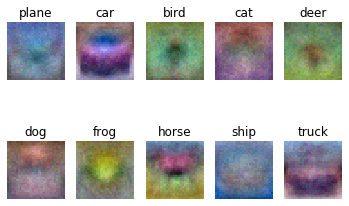

In [8]:
## Visualize the learned weights for each class
w = bestSoftmax.W[:-1,:] 
w = w.reshape(32, 32, 3, 10)

wMin, wMax = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - wMin) / (wMax - wMin)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])